#  Além da Linearidade (Moving Beyond Linearity)

A regressão linear padrão tem limitações significativas em termos de capacidade preditiva devido à sua suposição quase sempre aproximada e, às vezes, imprecisa de linearidade. Embora técnicas como ridge regression e o lasso tenham melhorado essa situação, elas ainda dependem, em certa medida, da suposição de linearidade.

Para superar essas limitações, exploraremos extensões mais flexíveis de modelos lineares e técnicas avançadas:

- **Regressão Polinomial:** Este método estende o modelo linear introduzindo preditores adicionais que são obtidos ao elevar cada preditor original a uma potência. Por exemplo, em uma regressão cúbica, usamos três variáveis: X, X² e X³, como preditores.

- **Splines de Regressão:** Splines são mais flexíveis do que polinômios e funções de etapa. Eles dividem o intervalo de X em regiões distintas, ajustando uma função polinomial aos dados em cada região. No entanto, essas funções polinomiais têm a restrição de se conectar suavemente nas fronteiras das regiões ou "knots".

- **Splines de Suavização:** Essas splines são semelhantes às splines de regressão, mas surgem em uma situação diferente. Elas são construídas minimizando um critério que envolve a soma residual dos quadrados sujeita a uma penalização de suavidade.

- **Regressão Local:** Este método é semelhante às splines, mas com uma diferença crucial. Aqui, as regiões podem se sobrepor, e essa sobreposição ocorre de maneira muito suave.

- **Modelos Aditivos Generalizados:** Esses modelos nos permitem estender essas técnicas para lidar com vários preditores, proporcionando maior flexibilidade na modelagem das relações entre a resposta e os preditores.

Essas abordagens nos ajudarão a superar a limitação da linearidade e a criar modelos mais precisos e flexíveis para análise de dados.

<b>Importando pacotes, bibliotecas e dados necessários:</b>

In [ ]:
pip install ISLP

In [ ]:
import numpy as np, pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (summarize,
poly,
ModelSpec as MS)
from statsmodels.stats.anova import anova_lm
from pygam import (s as s_gam,
l as l_gam,
f as f_gam,
LinearGAM,
LogisticGAM)
from ISLP.transforms import (BSpline,
NaturalSpline)
from ISLP.models import bs, ns
from ISLP.pygam import (approx_lam,
degrees_of_freedom,
plot as plot_gam,
anova as anova_gam)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from numpy.polynomial import Polynomial

import matplotlib.pyplot as plt
from math import sqrt


data = load_data('Wage')
data.head()

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


<b>**Criando conjuntos de treinamento e validação e plotando os dados para inspecionar a relação entre salário e idade:**</b>

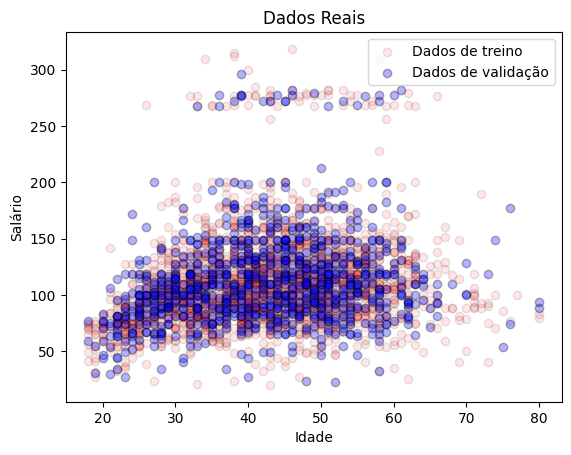

In [ ]:
data_x = data['age']
data_y = data['wage']

from sklearn.model_selection import train_test_split
train_x, valid_x, train_y, valid_y = train_test_split(data_x, data_y, test_size = 0.33, random_state = 1)

plt.scatter(train_x, train_y,  label='Dados de treino', facecolor='red', edgecolor='k', alpha=0.1)
plt.scatter(valid_x, valid_y,  label='Dados de validação', facecolor='Blue', edgecolor='k', alpha=0.3)
plt.xlabel('Idade')
plt.ylabel('Salário')
plt.title(f'Dados Reais')
plt.legend()
plt.show()

Linear Reg Model Coef: [0.72190831]
Linear Reg Model Intercept: 80.6528774116384
RMSE Linear Regression: 40.43668748857125


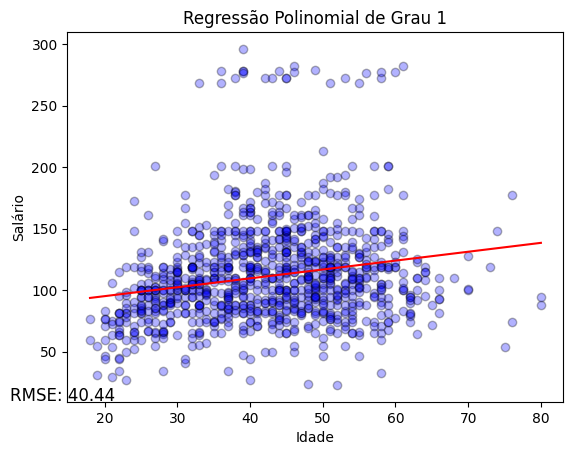

In [ ]:
x = train_x.values.reshape(-1, 1)
model = LinearRegression()
model.fit(x, train_y)

print("Linear Reg Model Coef:", model.coef_)
print("Linear Reg Model Intercept:", model.intercept_)

x2 = valid_x.values.reshape(-1, 1)
pred = model.predict(x2)

rmse = sqrt(mean_squared_error(valid_y, pred))
print("RMSE Linear Regression:", rmse)

xp = np.linspace(valid_x.min(), valid_x.max(), 70)
xp = xp.reshape(-1, 1)
pred_plot = model.predict(xp)

plt.scatter(valid_x, valid_y, facecolor='Blue', edgecolor='k', alpha=0.3)
plt.plot(xp, pred_plot, color='r')
plt.xlabel('Idade')
plt.ylabel('Salário')
plt.title(f'Regressão Polinomial de Grau 1')
plt.text(7, 10, f'RMSE: {rmse:.2f}', fontsize=12)
plt.show()

**Regressão Polinomial**

A maneira padrão de estender a regressão linear para configurações em que a relação entre os preditores e a resposta é não linear tem sido substituir o modelo linear padrão:

$$
y_i = \beta_0 + \beta_1 x_i + \epsilon_i
$$

por uma função polinomial:

$$
y_i = \beta_0 + \beta_1 x_i + \beta_2 x_i^2 + \beta_3 x_i^3 + \ldots + \beta_d x_i^d + \epsilon_i
$$

Nesta abordagem, conhecida como regressão polinomial, utilizamos polinômios de grau superior para criar uma curva extremamente não linear quando o grau d é suficientemente alto. É importante notar que os coeficientes de uma função polinomial podem ser facilmente estimados usando regressão linear de mínimos quadrados, pois isso se torna apenas um modelo linear padrão com preditores $x_i$, $x_i^2$, $x_i^3$, ..., $x_i^d$. No entanto, geralmente é incomum usar d maior que 3 ou 4, porque, para valores grandes de d, a curva polinomial pode se tornar excessivamente flexível e assumir formas muito estranhas. Isso é especialmente verdadeiro próximo à fronteira da variável X.

Agora, vamos aplicar essa ideia a um conjunto de dados:




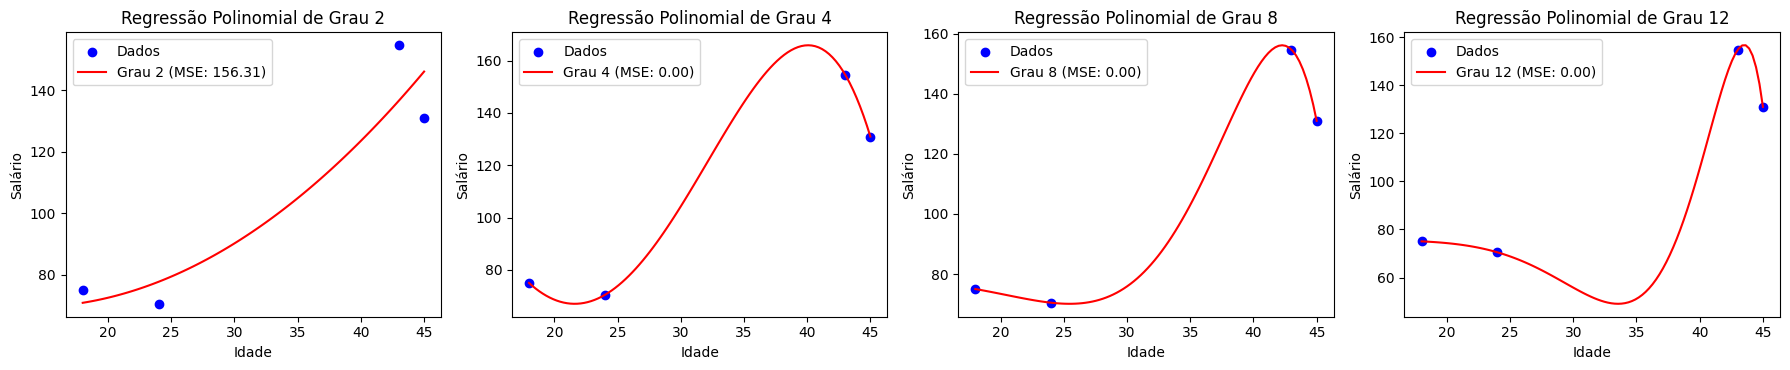

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Seus dados
age = np.array([18, 24, 45, 43])  # Idade
wage = np.array([75.04, 70.48, 130.98, 154.69])  # Salário

# Graus polinomiais a serem testados
degrees = [2, 4, 8, 12]

# Ajuste do tamanho da figura
plt.figure(figsize=(18, 4))

for i, degree in enumerate(degrees):
    plt.subplot(1, len(degrees), i + 1)
    plt.scatter(age, wage, label='Dados', color='blue')

    # Transformação polinomial dos dados
    poly = PolynomialFeatures(degree=degree)
    age_poly = poly.fit_transform(age.reshape(-1, 1))  # Correção aqui

    # Ajuste do modelo linear
    model = LinearRegression()
    model.fit(age_poly, wage)

    # Gerando valores previstos
    predicted_wage = model.predict(age_poly)

    # Calculando erro médio quadrático
    mse = mean_squared_error(wage, predicted_wage)

    # Visualização da curva de regressão polinomial
    x_range = np.linspace(min(age), max(age), 100)
    x_range_poly = poly.transform(x_range.reshape(-1, 1))
    y_range = model.predict(x_range_poly)

    plt.plot(x_range, y_range, label=f'Grau {degree} (MSE: {mse:.2f})', color='red')
    plt.xlabel('Idade')
    plt.ylabel('Salário')
    plt.title(f'Regressão Polinomial de Grau {degree}')
    plt.legend()

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Nestes gráficos, podemos notar que, à medida que aumentamos o grau do polinômio na regressão, como exemplificado pelo grau 12, ocorre uma distorção significativa nos resultados, mesmo com apenas 4 pontos do conjunto de dados. Essa distorção cria uma curva extremamente não linear, onde um segmento da curva fica muito menor do que o restante dos dados.


Agora vamos proceder  à análise do conjunto de dados presente no livro:

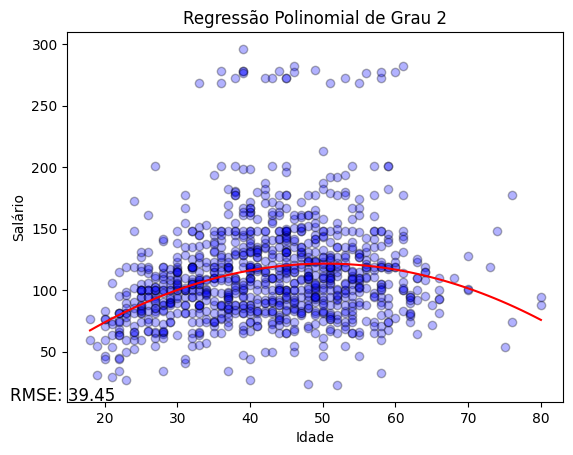

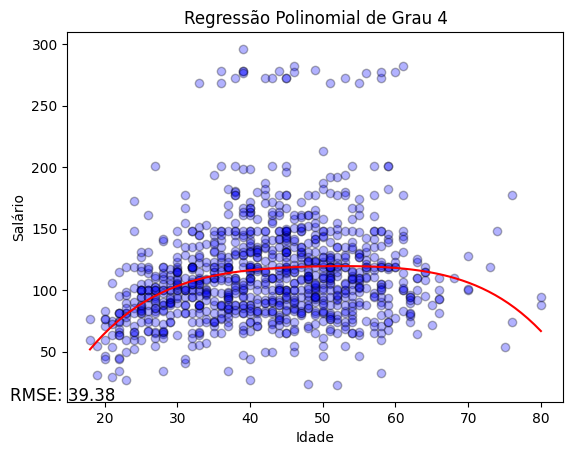

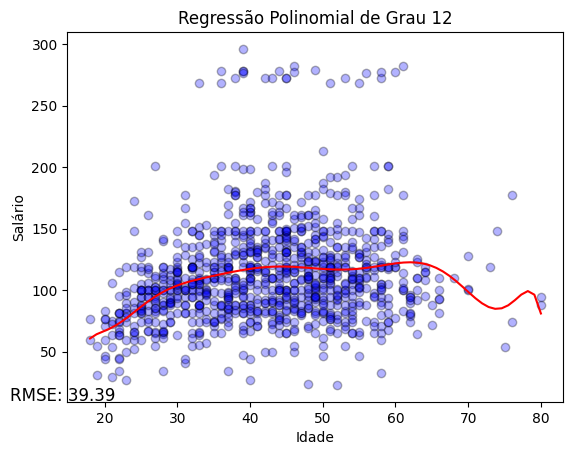

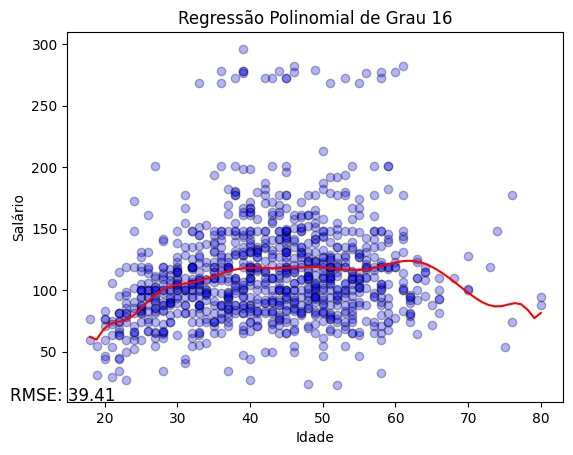

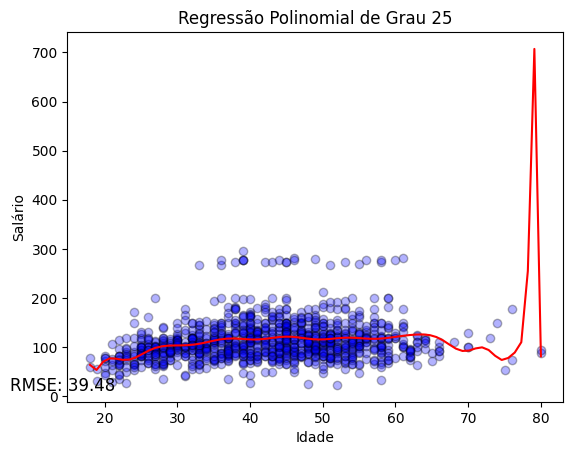

In [ ]:

# Graus dos polinômios a serem testados
graus = [2, 4, 12, 16, 25]

for grau in graus:
    # Ajuste o polinômio com o grau atual
    c = Polynomial.fit(train_x, train_y, deg=grau)
    pred = c(valid_x)

    # Calcule o RMSE
    rmse = sqrt(mean_squared_error(valid_y, pred))

    # Crie o gráfico
    xp = np.linspace(valid_x.min(), valid_x.max(), 70)
    pred_plot = c(xp)

    plt.scatter(valid_x, valid_y, facecolor='Blue', edgecolor='k', alpha=0.3)
    plt.plot(xp, pred_plot, color='r')
    plt.xlabel('Idade')
    plt.ylabel('Salário')
    plt.title(f'Regressão Polinomial de Grau {grau}')
    plt.text(7, 10, f'RMSE: {rmse:.2f}', fontsize=12)
    plt.show()



**O que é Regressão degrau (Step Functions)?**

Estamos tentando entender como a idade de uma pessoa afeta o seu salário

**Dividindo em Etapas:**

1. **Primeiro Passo:** Primeiro, criamos o que chamamos de "variáveis dummy". Isso é como se estivéssemos criando botões de ligar/desligar para diferentes faixas etárias. Por exemplo, podemos ter três botões: jovens, adultos e idosos. Esses botões representam se alguém pertence a uma dessas faixas etárias ou não.

2. **Segundo Passo:** Para cada pessoa, apertamos um desses botões com base na sua idade. Se alguém tiver menos de 25 anos, apertamos o botão "jovens", se tiver entre 25 e 35 anos, apertamos o botão "adultos", e se tiver mais de 35 anos, apertamos o botão "idosos".

3. **Terceiro Passo:** Agora, quando queremos saber como a idade afeta o salário, não precisamos fazer contas complicadas. Basta olhar quais botões estão ligados para aquela pessoa. Se o botão "jovens" estiver ligado, usamos uma média de salário para jovens; se o botão "adultos" estiver ligado, usamos a média de salário para adultos, e assim por diante.

A regressão degrau é útil porque nos permite entender como uma variável, como a idade, afeta outra variável, como o salário, de uma maneira fácil de interpretar. Em vez de tentar encontrar uma fórmula complicada, apenas dividimos em grupos e calculamos médias.


Estamos dividindo as idades em grupos usando a função pd.cut. Essa técnica nos ajuda a agrupar as idades em categorias distintas, facilitando a identificação de padrões ou tendências nos dados. Isso torna a análise mais compreensível e útil.

In [ ]:
df_cut, bins = pd.cut(train_x, 4, retbins = True, right = True)
df_cut.value_counts(sort = False)

(17.938, 33.5]    504
(33.5, 49.0]      941
(49.0, 64.5]      511
(64.5, 80.0]       54
Name: age, dtype: int64

In [ ]:
df_steps = pd.concat([train_x, df_cut, train_y], keys = ['age', 'age_cuts', 'wage'], axis = 1)
df_steps.head()

,age,age_cuts,wage
1382,49,"(33.5, 49.0]",117.146817
23,40,"(33.5, 49.0]",160.642475
2140,55,"(49.0, 64.5]",81.283253
1117,32,"(17.938, 33.5]",94.072715
933,42,"(33.5, 49.0]",75.043154


In [ ]:
df_steps_dummies = pd.get_dummies(df_cut)
df_steps_dummies.columns = ['17.938-33.5','33.5-49','49-64.5','64.5-80']
df_steps_dummies.head()

,17.938-33.5,33.5-49,49-64.5,64.5-80
1382,0,1,0,0
23,0,1,0,0
2140,0,0,1,0
1117,1,0,0,0
933,0,1,0,0


In [ ]:
fit3 = sm.GLM(df_steps.wage, df_steps_dummies).fit()
bin_mapping = np.digitize(valid_x, bins)

x_valid = pd.get_dummies(bin_mapping)
x_valid.head()

,1,2,3,4,5
0,0,0,1,0,0
1,0,1,0,0,0
2,0,0,1,0,0
3,0,1,0,0,0
4,1,0,0,0,0


In [ ]:
# coluna atipica
x_valid = pd.get_dummies(bin_mapping).drop([5], axis = 1)
pred2 = fit3.predict(x_valid)


print("RMSE for GLM:", sqrt(mean_squared_error(valid_y, pred2)))


RMSE for GLM: 39.99060078376046


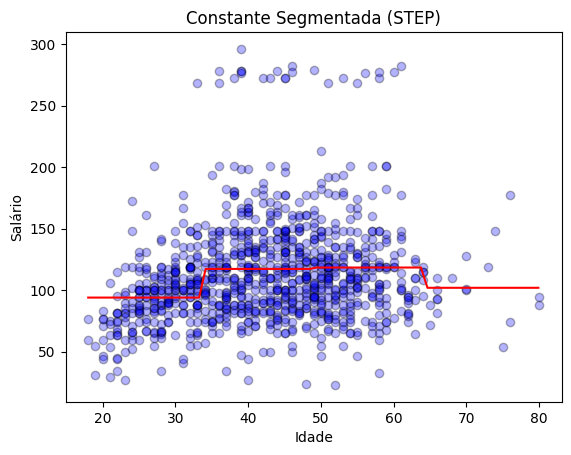

In [ ]:
# Cria um espaço linear para a idade
age_grid = np.linspace(valid_x.min(), valid_x.max()-0.1, 70)

# Segmentação baseada nas faixas
bin_mapping = np.digitize(age_grid, bins)

# Transforme em variáveis dummy
X_valid_2 = pd.get_dummies(bin_mapping)

# Previsões
pred2 = fit3.predict(X_valid_2)

# Plotagem dos resultados
plt.scatter(valid_x, valid_y, facecolor='Blue', edgecolor='k', alpha=0.3)
plt.plot(age_grid, pred2, c='r')

plt.xlabel('Idade')
plt.ylabel('Salário')
plt.title('Constante Segmentada (STEP)')
plt.show()


**Bases de Funções: Uma Abordagem Flexível para Modelagem**

Os modelos de regressão polinomial e degrau que discutimos anteriormente são, na verdade, casos especiais de uma abordagem mais ampla chamada de bases de funções. O cerne dessa abordagem é substituir diretamente a variável original $X$ por uma combinação de funções predefinidas, as quais chamamos de funções de base.

Em vez de modelar a relação entre $X$ e $Y$ de forma linear, ajustamos o modelo da seguinte maneira:

$$
y_i = \beta_0 + \beta_1b_1(x_i) + \beta_2b_2(x_i) + \beta_3b_3(x_i) + \ldots + \beta_Kb_K(x_i) + \epsilon_i.
$$

Aqui, $b_1(x_i)$, $b_2(x_i)$, $\ldots$, $b_K(x_i)$ representam as funções de base, que são escolhidas antecipadamente e não mudam durante o processo de ajuste do modelo. A vantagem dessa abordagem é que podemos capturar relações mais complexas entre $X$ e $Y$ usando essas funções de base.

Na regressão polinomial, as funções de base são simplesmente potências de $X$, como $b_j(x_i) = x_i^j$. Já na regressão degrau, usamos funções constantes em partes, representadas por $b_j(x_i) = I(c_j \leq x_i < c_{j+1})$, onde $c_j$ são os pontos de corte.

A estimativa dos coeficientes de regressão $\beta_0$, $\beta_1$, $\beta_2$, $\ldots$, $\beta_K$ é feita usando o método dos mínimos quadrados, semelhante à regressão linear simples.

Além das funções polinomiais e constantes em partes, existem muitas outras alternativas para escolher como funções de base, como wavelets e séries de Fourier. Na próxima seção, exploraremos uma escolha muito comum: as splines de regressão, que oferecem grande flexibilidade na modelagem de relações complexas entre variáveis.


# Regression Splines

## Polinômios em Partes (Piecewise Polynomials)

Ao invés de ajustar um único polinômio de alto grau que abranja toda a faixa de valores de X, a regressão polinomial em partes adota uma abordagem diferente. Ela consiste em ajustar polinômios de baixo grau separadamente em diferentes regiões de X.

Por exemplo, podemos considerar o seguinte modelo:

$y_i = \beta_0 + \beta_1x_i + \beta_2x_i^2 + \beta_3x_i^3 + e_i$

Quando adicionamos um nó em um ponto $c$, o modelo resultante tem duas partes distintas:

1. Para $x_i < c$, os coeficientes são $\beta_{01}$, $\beta_{11}$, $\beta_{21}$ e $\beta_{31}$.
2. Para $x_i \geq c$, os coeficientes são $\beta_{02}$, $\beta_{12}$, $\beta_{22}$ e $\beta_{32}$.

Essencialmente, estamos dividindo nossos dados em duas partes com base no valor de c e ajustando dois polinômios diferentes às duas regiões distintas.

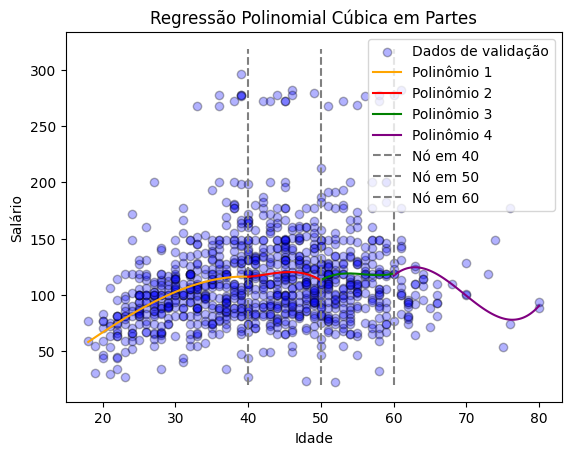

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Pontos de corte (nós) - exemplo com três nós
c_values = [40, 50, 60]  # Lista de nós

# Graus dos polinômios - exemplo com grau 3 para todos os polinômios
degrees = [3, 3, 3]  # Graus correspondentes aos nós

# Inicializando listas para armazenar os grids de idade, coeficientes e previsões
age_grids = []
coeffs = []
predictions = []

# Loop para criar grids, ajustar polinômios e fazer previsões para cada nó, incluindo o último intervalo
for i, c in enumerate(c_values):
    # Criando o grid de idade para o nó atual
    if i == 0:
        age_min = train_x.min()
        age_max = c
    else:
        age_min = c_values[i - 1]
        age_max = c

    age_grid = np.linspace(age_min, age_max, 100)
    age_grids.append(age_grid)

    # Dividindo os dados de treino em duas partes com base no nó atual
    train_x_part = train_x[(train_x >= age_min) & (train_x <= age_max)]
    train_y_part = train_y[(train_x >= age_min) & (train_x <= age_max)]

    # Ajustando polinômio com o grau correspondente
    coeffs_part = np.polyfit(train_x_part, train_y_part, degrees[i])
    coeffs.append(coeffs_part)

    # Fazendo previsões para o conjunto de dados de idade criado
    predictions_part = np.polyval(coeffs_part, age_grid)

    predictions.append(predictions_part)

# Lidando com o último intervalo
age_min = c_values[-1]
age_max = train_x.max()
age_grid = np.linspace(age_min, age_max, 100)
age_grids.append(age_grid)

train_x_part = train_x[(train_x >= age_min)]
train_y_part = train_y[(train_x >= age_min)]
# Ajustando polinômio com o grau correspondente
coeffs_part = np.polyfit(train_x_part, train_y_part, degrees[i])
coeffs.append(coeffs_part)

# Fazendo previsões para o conjunto de dados de idade criado
predictions_part = np.polyval(coeffs_part, age_grid)
predictions.append(predictions_part)

# Plotagem dos resultados
plt.scatter(valid_x, valid_y, facecolor='Blue', label='Dados de validação', edgecolor='k', alpha=0.3)

# Plotagem das curvas de ajuste nos conjuntos de dados de idade
colors = ['orange', 'red', 'green']  # Cores para as curvas
for i in range(len(c_values)):
    plt.plot(age_grids[i], predictions[i], linestyle='-', color=colors[i], label=f'Polinômio {i + 1}')
# Plotagem do último intervalo
plt.plot(age_grids[-1], predictions[-1], linestyle='-', color='purple', label=f'Polinômio {len(c_values) + 1}')

# Conectando os nós em c
for c in c_values:
    plt.plot([c, c], [min(train_y), max(train_y)], linestyle='--', color='gray', label=f'Nó em {c}')



plt.xlabel('Idade')
plt.ylabel('Salário')
plt.title('Regressão Polinomial Cúbica em Partes')
plt.legend()
plt.show()


 Podemos ajustar curvas mais flexíveis usando polinômios em partes, mas é importante impor restrições para evitar resultados não realistas. Isso pode ser feito exigindo continuidade nas curvas ajustadas e até mesmo nas derivadas das curvas em pontos específicos, como nós. Quanto mais restrições impusermos, menos graus de liberdade teremos no ajuste, resultando em curvas mais suaves e realistas. Existem diferentes tipos de splines, como splines cúbicos e lineares, que podem ser usados com várias restrições para atender às necessidades específicas do problema.


## Spline Cúbico vs. Spline Natural:

Ao estudar como ajustar curvas suaves a dados complicados, nos deparamos com duas técnicas: splines cúbicos e splines naturais. Ambos têm suas vantagens, e a escolha entre eles é crucial para obter resultados precisos e compreensíveis.

**Splines**:

Splines são uma maneira inteligente de modelar curvas suaves a partir de dados complexos. Ao invés de utilizar um único polinômio, que pode ser rígido e não se ajustar bem a certos tipos de dados, splines dividem a curva em pequenos trechos, cada um modelado por um polinômio. A mágica acontece nos "nós," pontos onde esses trechos se conectam de forma contínua, criando uma curva geral suave e adaptável.

**Mínimos Quadrados - Encontrando a Melhor Combinação**

Quando usamos splines, seja cúbico ou natural, usamos um método chamado mínimos quadrados. Esse método ajuda a encontrar a melhor combinação de polinômios em cada trecho para ajustar nossos dados. Em outras palavras, ele procura os coeficientes ideais para cada polinômio de forma que, quando todos se juntam nos "nós", a curva resultante se ajuste da melhor forma possível aos nossos dados. Em resumo, estamos minimizando a diferença entre a curva ajustada e os dados reais, o que nos dá uma estimativa precisa da relação subjacente.

**Spline Cúbico vs. Spline Natural**

Agora, a escolha entre spline cúbico e spline natural depende de suas características:
- O spline cúbico usa polinômios de terceiro grau em seus trechos, oferecendo flexibilidade. No entanto, essa flexibilidade pode levar a ajustes irregulares, especialmente nos "nós".
- O spline natural também é cúbico, mas adiciona restrições. Além de garantir a continuidade da segunda derivada nos "nós," ele também exige que a curva seja linear nas bordas dos dados, proporcionando maior estabilidade nessas áreas críticas.

**Grau de Liberdade e Considerações Finais**

O grau de flexibilidade de um spline é controlado pelo número de "nós." Cada restrição imposta em um spline reduz a complexidade, liberando graus de liberdade. Portanto, um spline cúbico com K "nós" utiliza um total de 4 + K graus de liberdade.

Um spline natural tem K graus de liberdade, onde K representa o número de "nós" ou pontos de transição onde ocorrem as correções nos polinômios.

O spline cúbico tem 4 + K graus de liberdade devido à natureza da sua construção. Vamos explicar isso em detalhes:

1. **Intercepto (1 grau de liberdade):** Começando com um spline cúbico, temos um intercepto, que é um coeficiente que controla o deslocamento vertical da curva ajustada.

2. **Coeficientes para Termos de Potência (3 graus de liberdade):** Um spline cúbico utiliza polinômios de terceiro grau em cada segmento entre os "nós." Portanto, para cada segmento, precisamos estimar três coeficientes que controlam os termos de potência (x, x² e x³) do polinômio cúbico.

3. **Nós (K graus de liberdade):** Para criar uma curva suave e flexível, escolhemos os "nós" onde os polinômios se encontram. Cada "nó" adiciona um grau de liberdade, pois podemos ajustar sua posição para melhorar o ajuste aos dados.

No total, temos 4 + K graus de liberdade no spline cúbico: 1 para o intercepto, 3 para os termos de potência e K para os "nós." Isso nos permite controlar a flexibilidade da curva ajustada e adaptá-la às características dos dados.

##  Escolhendo o Número e a Localização dos Nós (Choosing the Number and Locations of the Knots)

Ao ajustar uma spline, a escolha da localização dos "nós" é importante. Os  "nós" determinam onde a spline pode mudar rapidamente. Você pode colocar mais "nós" em áreas onde a função deve variar rapidamente e menos  "nós"  onde a função é mais estável. No entanto, geralmente, os "nós" são colocados uniformemente, dividindo os dados em partes iguais. Uma maneira objetiva de determinar quantos  "nós"  usar é usar a validação cruzada. Nesse método:

- Ajustamos uma spline com um certo número de "nós" aos dados.
- Usamos a spline para fazer previsões para a parte retida.
- Repetimos esse processo várias vezes até que cada observação tenha sido deixada de fora uma vez.
- Calculamos o erro médio quadrado global da validação cruzada.
- Escolhemos o número de "nós" que resulta no menor erro médio quadrado.

In [ ]:
def create_basis(data_x, num_nodes, spline_type='natural'):
    if spline_type == 'natural':
        basis = MS([ns('age', df=num_nodes)]).fit(data_x)
    else:
        basis = MS([bs('age', df=num_nodes, degree=3)]).fit(data_x)
    return basis

def transform_data(basis, data_x, age_df):
    X = basis.transform(data_x)
    Xnew = basis.transform(age_df)
    return X, Xnew

def fit_model(data_y, X):
    M = sm.OLS(data_y, X).fit()
    return M

def predict_mean(M, Xnew):
    preds = M.get_prediction(Xnew).predicted_mean
    predicted_df = pd.DataFrame({'Predicted': preds})
    return predicted_df

def fit_spline(data_x, data_y, age_df, num_nodes, spline_type='natural'):
    basis = create_basis(data_x, num_nodes, spline_type)
    X, Xnew = transform_data(basis, data_x, age_df)
    M = fit_model(data_y, X)
    predicted_df = predict_mean(M, Xnew)
    return predicted_df


Número do nó ideal para Spline Natural: 6, MSE: 3601.8267667482364
Número do nó ideal para Spline Cúbica: 10, MSE: 3592.748476741308
Número do nó indesejavel para Spline Natural: 4, MSE: 3624.439574663562
Número do nó indesejavel para Spline Cúbica: 6, MSE: 3630.0514974378007


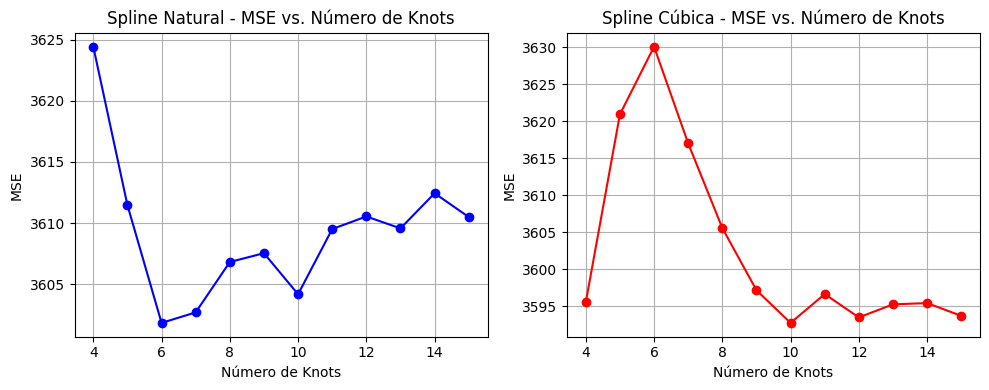

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

# Converter em DataFrames
data_x = pd.DataFrame(data['age'])
data_y = pd.DataFrame(data['wage'])


# Transforma age em uma matriz unidimensional
age_array = data_x.values.reshape(-1)

# Define o número máximo de nós que você deseja testar
max_nodes = 15

# Cria uma lista para armazenar os erros MSE para Spline Natural
mse_list_ns = []

# Cria uma lista para armazenar os erros MSE para Spline Cúbica
mse_list_cubic = []

# Transforma age em uma matriz unidimensional
age_array = data_x.values.reshape(-1)

# cria age_df
age_grid = np.linspace(age_array.min(), age_array.max(), 100)
age_df = pd.DataFrame({'age': age_grid})

# Testar diferentes números de nós para Natural Spline e Spline Cúbica
#  a cubic spline with K knots uses K+4 degrees of freedom.

# Vetor de números de nós
num_nodes_list = list(range(4, max_nodes + 1))

for num_nodes in num_nodes_list:
    # Criar o modelo de Spline Natural com o número atual de nós

    pred_ns = fit_spline(data_x, data_y, age_df, num_nodes, spline_type='natural')
    mse_ns = mean_squared_error(pred_ns, age_df.values)

    pred_cubic = fit_spline(data_x, data_y, age_df, num_nodes, spline_type='cubic')
    mse_cubic = mean_squared_error(pred_cubic, age_df.values)

    # Adicione os erros MSE à lista correspondente
    mse_list_ns.append((num_nodes, mse_ns))
    mse_list_cubic.append((num_nodes, mse_cubic))

# Número do nó com o menor erro MSE para Spline Natural
best_node_ns, best_mse_ns = min(mse_list_ns, key=lambda x: x[1])

# Número do nó com o menor erro MSE para Spline Cúbica
best_node_cubic, best_mse_cubic = min(mse_list_cubic, key=lambda x: x[1])


# Número do nó com o maior erro MSE para Spline Natural
worst_node_ns, worst_mse_ns = max(mse_list_ns, key=lambda x: x[1])
# Número do nó com o maior erro MSE para Spline Cúbica
worst_node_cubic, worst_mse_cubic = max(mse_list_cubic, key=lambda x: x[1])

print(f'Número do nó ideal para Spline Natural: {best_node_ns}, MSE: {best_mse_ns}')
print(f'Número do nó ideal para Spline Cúbica: {best_node_cubic}, MSE: {best_mse_cubic}')
print(f'Número do nó indesejavel para Spline Natural: {worst_node_ns}, MSE: {worst_mse_ns}')
print(f'Número do nó indesejavel para Spline Cúbica: {worst_node_cubic}, MSE: {worst_mse_cubic}')

#  gráfico de número de nós x MSE para ambas as Spline Natural e Spline Cúbica

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(num_nodes_list, [tupla[1] for tupla in  mse_list_ns], marker='o', linestyle='-', color='b')
plt.title('Spline Natural - MSE vs. Número de Knots')
plt.xlabel('Número de Knots')
plt.ylabel('MSE')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(num_nodes_list, [tupla[1] for tupla in mse_list_cubic ] , marker='o', linestyle='-', color='r')
plt.title('Spline Cúbica - MSE vs. Número de Knots')
plt.xlabel('Número de Knots')
plt.ylabel('MSE')
plt.grid(True)

plt.tight_layout()
plt.show()


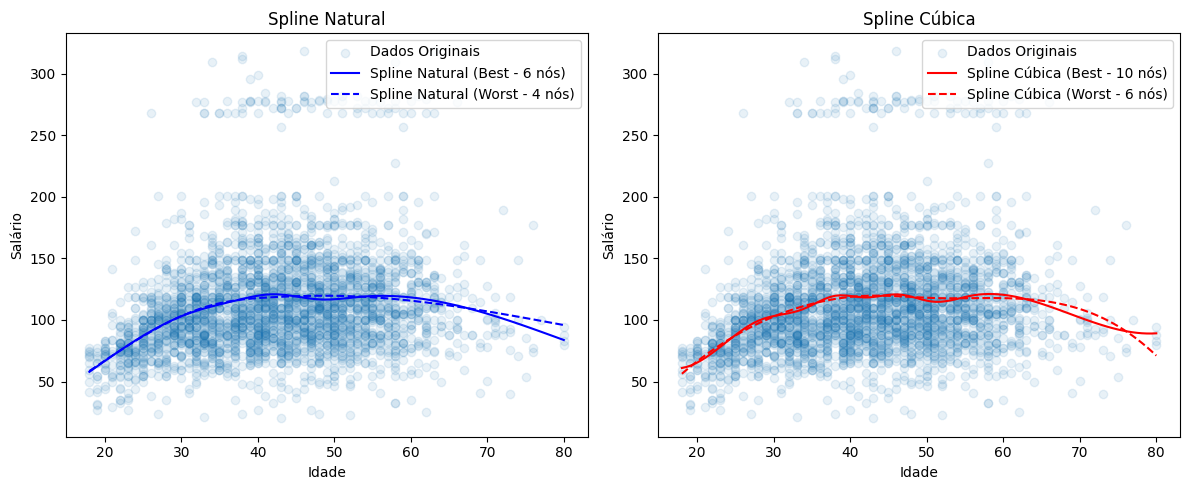

In [ ]:
# Subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# (Spline Natural)
ax1.scatter(data_x, data_y, label='Dados Originais', alpha=0.1)
preds_best_ns = fit_spline(data_x, data_y, age_df, best_node_ns)
preds_worst_ns = fit_spline(data_x, data_y, age_df, worst_node_ns)
ax1.plot(age_df['age'], preds_best_ns, label=f'Spline Natural (Best - {best_node_ns} nós)', linestyle='-', color='b')
ax1.plot(age_df['age'], preds_worst_ns, label=f'Spline Natural (Worst - {worst_node_ns} nós)', linestyle='--', color='b')
ax1.set_title('Spline Natural')
ax1.set_xlabel('Idade')
ax1.set_ylabel('Salário')
ax1.legend()

# (Spline Cúbica)
ax2.scatter(data_x, data_y, label='Dados Originais', alpha=0.1)
preds_best_cubic = fit_spline(data_x, data_y, age_df, best_node_cubic, spline_type='cubic')
preds_worst_cubic = fit_spline(data_x, data_y, age_df, worst_node_cubic, spline_type='cubic' )
ax2.plot(age_df['age'], preds_best_cubic, label=f'Spline Cúbica (Best - {best_node_cubic} nós)', linestyle='-', color='r')
ax2.plot(age_df['age'], preds_worst_cubic, label=f'Spline Cúbica (Worst - {worst_node_cubic} nós)', linestyle='--', color='r')
ax2.set_title('Spline Cúbica')
ax2.set_xlabel('Idade')
ax2.set_ylabel('Salário')
ax2.legend()

# Ajuste o layout
plt.tight_layout()
plt.show()

#  Splines de Suavização (Smoothing Splines)

## Uma Visão Geral das Splines de Suavização (An overview of Smoothing Splines)

O que queremos encontrar aqui é uma função $g(x)$ que ajuste os dados observados da forma mais suave possível, ou seja, queremos encontrar um RSS que seja o menor possível e diferente de 0.

O smoothing spline nesse caso será dado pela função g que minimiza:
$$\sum_{i=1}^n (y_i - g(x_i))^2 + \lambda \int g''(t)^2dt$$
Onde, $\lambda > 0$ é o parâmetro de ajuste. O primeiro termo da expressão se refere a função de perda e o segundo é o termo que penaliza a variação em g.

O spline de suavização nada mais é do que um spline cubico natural com nós em cada valor único de $x_i$

## Escolhendo o Parâmetro de Suavização $\lambda$ (Choosing the Smoothing Parameter $\lambda$)

Ter um nó em cada ponto nos traz a ideia de um modelo com alta flexibilidade e consequentemente um alto grau de liberdade. E é justamente por isso que o parâmetro lambda se torna importante, ele que será o responsável por por contralar a suavização do smoothing spline, afetando os graus de liberdade efetivo.
Se λ aumenta de 0 a ∞ os graus de liberdade efetivo  ($df_{λ}$) decrescem de n para 2. Quanto maior for $df_{λ}$ mais flexivel é o modelo (menor viés e maior variância).
Escrevendo a seguinte expressão:
$$\hat{g}_\lambda = S_\lambda y$$

Podemos definir os graus de liberdade efetivo como sendo a soma dos elementos da diagonal principal da matriz $S_\lambda$:
$$df_λ = ∑^n_{i=1} \{S_λ\}_{ii}$$


Um problema desse modelo é definir o valor de lambda e para isso podemos utilizar cross-validation, ou seja encontraremoso valor de lambda que torna o erro RSS da validação cruzada o menor possível. Esse erro (LOOCV) pode ser calculado facilmente para splines de suavização como segue:
 𝛌 será dado pelo valor que faz o cross validation RSS ser o menor possível.
$$RSS_{cv}(\lambda) = \sum_{i-1}^n (y_i - \hat{g}^{(-i)}_\lambda (x_i))^2 = \sum_{i=1}^n\left[ \frac{y_i - \hat{g}_{\lambda}(x_i)}{1 - \{S_{\lambda}\}_{ii}} \right]^2$$

O valor de lambda que minimiza a expressão acima será nosso valor ótimo para o parâmetro de suavização.




100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


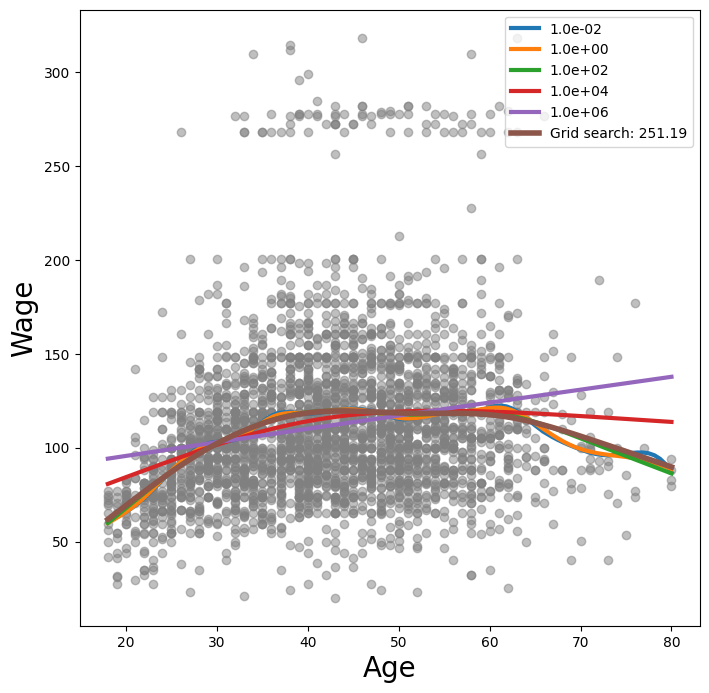

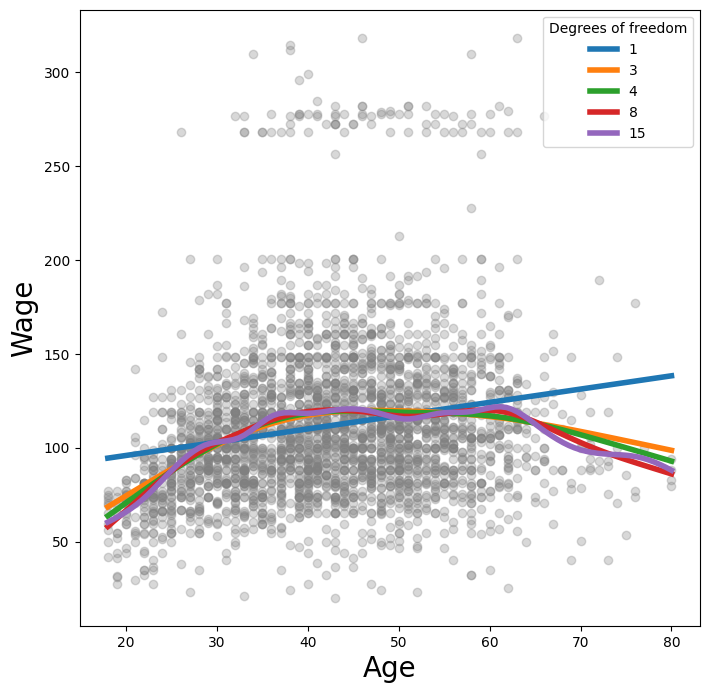

In [ ]:
# Carregamento dos dados
Wage = load_data('Wage')
y = Wage['wage']
age = Wage['age']

# Modelo LinearGAM com um termo de suavização linear para 'age'
# e um parâmetro de suavização inicial (lambda) de 0.6
X_age = np.asarray(age).reshape((-1,1))
gam = LinearGAM(s_gam(0, lam=0.6))
gam.fit(X_age, y)

fig, ax = subplots(figsize=(8,8))
ax.scatter(age, y, facecolor='gray', alpha=0.5)
# Fazer a predição com diferentes valores de lambda
for lam in np.logspace(-2, 6, 5):
  gam = LinearGAM(s_gam(0, lam=lam)).fit(X_age, y)
  ax.plot(age_grid ,
          gam.predict(age_grid),
          label='{:.1e}'.format(lam),
          linewidth=3)
ax.set_xlabel('Age', fontsize=20)
ax.set_ylabel('Wage', fontsize=20);
ax.legend(title='$\lambda$')

# Pesquisa em grade para encontrar o valor ótimo de lambda
gam_opt = gam.gridsearch(X_age, y)
optimal_lambda = gam_opt.lam

ax.plot(age_grid ,
gam_opt.predict(age_grid),
label="Grid search: {:.2f}".format(optimal_lambda[0][0]),
linewidth=4)
ax.legend()
fig

# Define um termo de suavização para a idade
# Calcula o valor de lambda que corresponde a 4 graus de liberdade efetivos
# Define o valor de lambda para o termo de suavização da idade
# Calcula os graus de liberdade efetivos
age_term = gam.terms[0]
lam_4 = approx_lam(X_age, age_term , 4)
age_term.lam = lam_4
degrees_of_freedom(X_age, age_term)

cv_results = {}
fig, ax = subplots(figsize=(8,8))
ax.scatter(X_age,
y,
facecolor='gray',
alpha=0.3)
for df in [1,3,4,8,15]:
  lam = approx_lam(X_age, age_term , df+1)
  age_term.lam = lam
  gam.fit(X_age, y)
  ax.plot(age_grid ,
          gam.predict(age_grid),
          label='{:d}'.format(df),
          linewidth=4)
ax.set_xlabel('Age', fontsize=20)
ax.set_ylabel('Wage', fontsize=20);
ax.legend(title='Degrees of freedom')

# Regressão Local (Local Regression)

A regressão local é mais um método para ajustar funções não lineares. O método é baseado em ajustar um ponto $x_0$ utilizando apenas os dados de treinamento da região do ponto alvo e diferente do spline aqui as regiões pode se cruzar.
O modelo necessita da definição dos seguintes parâmetros:
1. Span (s): definirá qual a proporção de pontos usados para calcular a regressão local em x_0. $$s = \frac{k}{n}$$
2. Peso ($K_0$):  $$K_{i0} = K(x_i, x_0)$$

Com os dados e parâmetros definidos basta ajustar uma regressão de mínimos quadrados ponderados do $y_i$ no $x_i$ usando os pesos mencionados no item 2, como segue:
$$\sum_{i=1}^n K_{i0}(y_i = \beta_0 - \beta_1x_i)^2$$

No fim o ajuste para $x_0$ seré dado por $\hat{f}(x_0) = \hat{\beta}_0 + \hat{\beta}_1x_0$

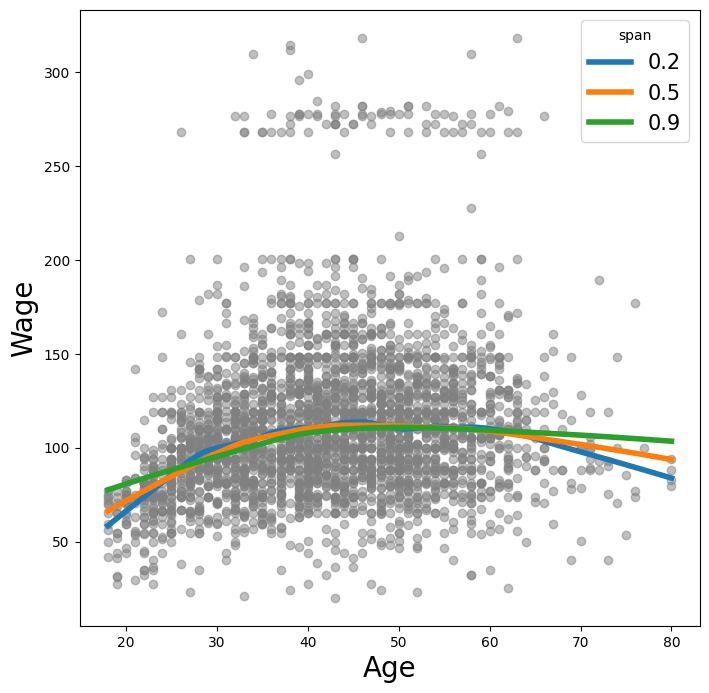

In [ ]:
import statsmodels.api as sm
from matplotlib.pyplot import subplots

lowess = sm.nonparametric.lowess
fig, ax = subplots(figsize=(8,8))
Wage = load_data('Wage')
y = Wage['wage']
age = Wage['age']
age_grid = np.linspace(age.min(),
age.max(),
100)

ax.scatter(age, y, facecolor='gray', alpha=0.5)
for span in [0.2, 0.5, 0.9]:
  fitted = lowess(y,
  age,
  frac=span,
  xvals=age_grid)
  ax.plot(age_grid,
  fitted,
  label='{:.1f}'.format(span),
  linewidth=4)
ax.set_xlabel('Age', fontsize=20)
ax.set_ylabel('Wage', fontsize=20);
ax.legend(title='span', fontsize=15);

#  Modelos Aditivos Generalizados (Generalized Additive Models (GAMs))

Nos modelos anteriores estavamos estudando uma maneira de prever uma resposta Y com base em um único preditor X. Agora iremos ver como prever Y com base em vários preditores $X_1, X_2, ..., X_p$.

## GAMs para Problemas de Regressão (GAMs for Regression Problems)

Para transformar um modelo de regressão linear de forma a permitir uma relação não linear entre as features e a resposta iremos trocar cada um dos componentes lineares ($\beta_jx_{ij}$) por uma função não linear ($f_j(x_{ij})$), com isso obteremos o seguinte modelo:
$$y_i = \beta_0 + \sum_{j=1}^p f_j(x_{ij}) + ϵ_i = \beta_0 + f_1(x_{i1}) + f_2(x_{i2}) + ... + f_p(x_{ip}) + \epsilon_i$$

Esse é um exemplo de um modelo aditivo, onde calculamos separadamente cada f_j para cada X_j e depois somamos todas as contribuições. Nós podemos utilizar qualquer um dos metodos visto a cima para ajustar o nosso modelo aditivo. Por exemplo, para os dados de salários, podemos ter:
$$wage = \beta_0 + f_1(year) + f_2(age) + f_3(education) + ϵ$$
Nesse exemplo year e age são variaveis quantitativas e podem ser ajustados , por exemplo, segundo o modelo de splines natural, já a variavel education é é qualitativa e pode ser ajustada utilizando as variáveis dummy.


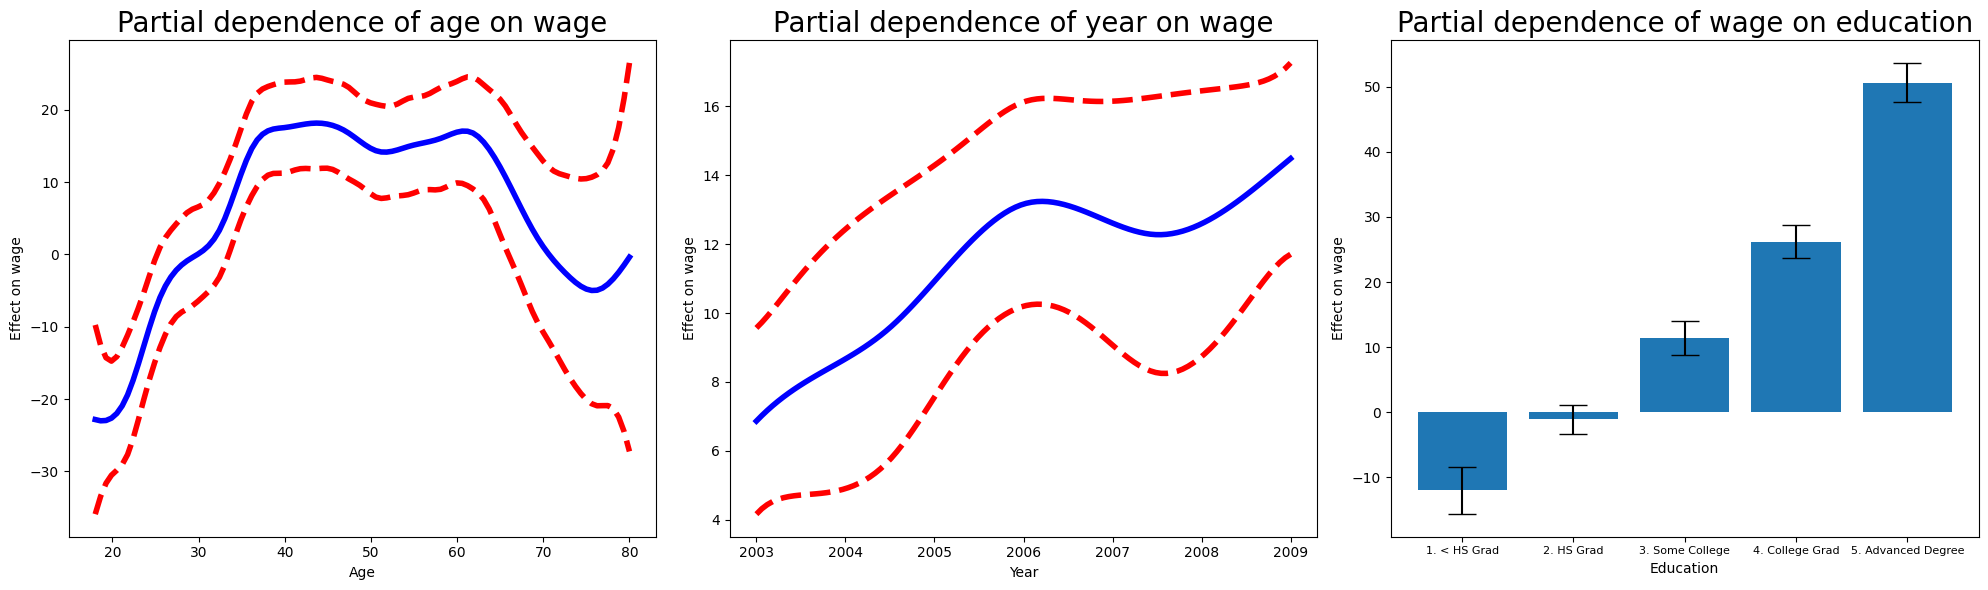

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Ajustando um spline natural com 4 graus de liberdade à idade e 5 ao ano
ns_age = NaturalSpline(df=4).fit(age)
ns_year = NaturalSpline(df=5).fit(Wage['year'])
# Criação de uma matriz combinada
Xs = [ns_age.transform(age),
      ns_year.transform(Wage['year']),
      pd.get_dummies(Wage['education']).values]
X_bh = np.hstack(Xs)
# Ajuste de um modelo de regressão linear aos dados com as características criadas
gam_bh = sm.OLS(y, X_bh).fit()

# Criando uma matriz de características para a idade no grid
age_grid = np.linspace(age.min(),
                       age.max(),
                       100)
X_age_bh = X_bh.copy()[:100]
X_age_bh[:] = X_bh[:].mean(0)[None ,:]
X_age_bh[:,:4] = ns_age.transform(age_grid)
# Obtendo previsões e intervalos de confiança usando o modelo ajustado
preds = gam_bh.get_prediction(X_age_bh)
bounds_age = preds.conf_int(alpha=0.05)
partial_age = preds.predicted_mean
center = partial_age.mean()
partial_age -= center
bounds_age -= center

# Criando um modelo de GAM linear completo
gam_full = LinearGAM(s_gam(0) +
s_gam(1, n_splines=7) +
f_gam(2, lam=0))
# Criando uma matriz de características para o modelo completo
Xgam = np.column_stack([age,
Wage['year'],
Wage['education'].cat.codes])
gam_full = gam_full.fit(Xgam, y)
# fig, ax = subplots(figsize=(8,8))
ax = axes[0]
plot_gam(gam_full , 0, ax=ax)
ax.set_xlabel('Age')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of age on wage',
fontsize=20)

age_term = gam_full.terms[0]
age_term.lam = approx_lam(Xgam, age_term , df=4+1)
year_term = gam_full.terms[1]
year_term.lam = approx_lam(Xgam, year_term , df=4+1)
gam_full = gam_full.fit(Xgam, y)
# fig, ax = subplots(figsize=(8,8))
ax = axes[1]
plot_gam(gam_full ,
1,
ax=ax)
ax.set_xlabel('Year')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of year on wage', fontsize=20)

# fig, ax = subplots(figsize=(8, 8))
ax = axes[2]
ax = plot_gam(gam_full , 2)
ax.set_xlabel('Education')
ax.set_ylabel('Effect on wage')

ax.set_title('Partial dependence of wage on education',
fontsize=20);
ax.set_xticklabels(Wage['education'].cat.categories , fontsize=8)

# Ajuste o layout para evitar sobreposição de rótulos
plt.tight_layout()

# Mostre a figura com os gráficos lado a lado
plt.show()


## GAMs para Problemas de Classificação (GAMs for Classification Problems)

Uso de Gams quando Y é qualitativo. Vamos assumir que Y assume valor 0 ou 1, estamos interessados em modelar a probabilidade condicional que representa a probabilidade de que Y seja igual a 1, ou seja, $p(X) = Pr(Y=1|X)$.

Temos que o modelo de regressão logistico GAM é:
$$log \left(\frac{p(X)}{1 - p(X)}\right) = \beta_0 + f_1(X_1) + f_2(X_2) + ... + f_p(X_p)$$

A esquerda temos a probabilidade $p(X) = Pr(Y=1|X)$ versus $p(X) = Pr(Y=0|X)$.

Um exemplo de aplicação desse modelo dados os nossos dados seria por exemplo prever a probabilidade da renda de um individual ser maior do que $250,000 por ano.

$$log \left(\frac{p(X)}{1 - p(X)}\right) = \beta_0 + \beta_1 \times \text{year} + f_2(\text{age}) + f_3(\text{education})$$
onde,
$$p(X) = Pr(wage > 250 | year,age,educaion)$$


### Testes ANOVA para Modelos Aditivos (ANOVA Tests for Additive Models)

In [ ]:
# Cria um modelo LinearGAM (Generalized Additive Model) com termo de idade (age_term) e uma função suave com 2 nós (f_gam)
# Define lambda (parâmetro de suavização) como 0 para a função suave
gam_0 = LinearGAM(age_term + f_gam(2, lam=0))
gam_0.fit(Xgam, y)

# Cria outro modelo LinearGAM adicionando termos de idade (age_term),
# uma função suave linear (l_gam) com lambda 0 e uma função suave com 2 nós (f_gam) com lambda 0
gam_linear = LinearGAM(age_term +
l_gam(1, lam=0) +
f_gam(2, lam=0))
gam_linear.fit(Xgam, y)

# Calcula a análise de variância (ANOVA) entre os dois modelos e o modelo completo (gam_full)
anova_gam(gam_0, gam_linear, gam_full)

,deviance,df,deviance_diff,df_diff,F,pvalue
0,3.714362e+06,2991.004005,NaN,NaN,NaN,NaN
1,3.696746e+06,2990.005190,17616.542840,0.998815,14.265131,0.002314
2,3.693143e+06,2987.007254,3602.893655,2.997936,0.972007,0.435579


In [ ]:
# Gera o resumo do modelo completo gam_full
gam_full.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     12.9927
Link Function:                     IdentityLink Log Likelihood:                                 -24117.907
Number of Samples:                         3000 AIC:                                            48263.7995
                                                AICc:                                             48263.94
                                                GCV:                                             1246.1129
                                                Scale:                                           1236.4024
                                                Pseudo R-Squared:                                   0.2928
Feature Function                  Lam

<ipython-input-23-dd2b60753e24>:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_full.summary()


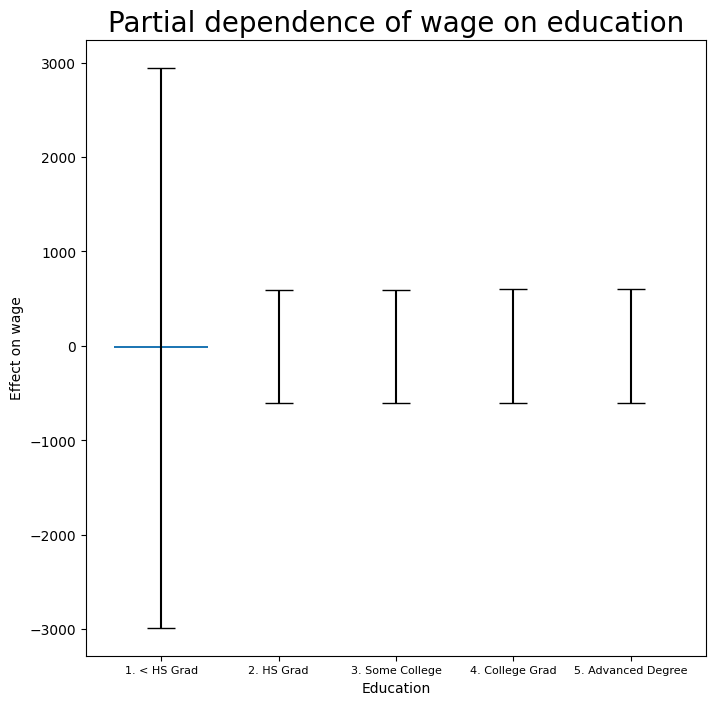

In [ ]:
Yhat = gam_full.predict(Xgam)
high_earn = Wage['high_earn'] = y > 250

# Cria um modelo LogisticGAM com termo de idade (age_term),
# uma função suave linear (l_gam) com lambda 0 e uma função suave com 2 nós (f_gam) com lambda 0
gam_logit = LogisticGAM(age_term +
l_gam(1, lam=0) +
f_gam(2, lam=0))
gam_logit.fit(Xgam, high_earn)

fig, ax = subplots(figsize=(8, 8))
ax = plot_gam(gam_logit, 2)
ax.set_xlabel('Education')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of wage on education',
fontsize=20);
ax.set_xticklabels(Wage['education'].cat.categories, fontsize=8);

In [ ]:

# Calcula a tabela de contingência cruzada entre 'high_earn' e 'education'
pd.crosstab(Wage['high_earn'], Wage['education'])

education,1. < HS Grad,2. HS Grad,3. Some College,4. College Grad,5. Advanced Degree
high_earn,,,,,
False,268,966,643,663,381
True,0,5,7,22,45


In [ ]:
only_hs = Wage['education'] == '1. < HS Grad'
Wage_ = Wage.loc[~only_hs]
Xgam_ = np.column_stack([Wage_['age'],
Wage_['year'],
Wage_['education'].cat.codes -1])
high_earn_ = Wage_['high_earn']

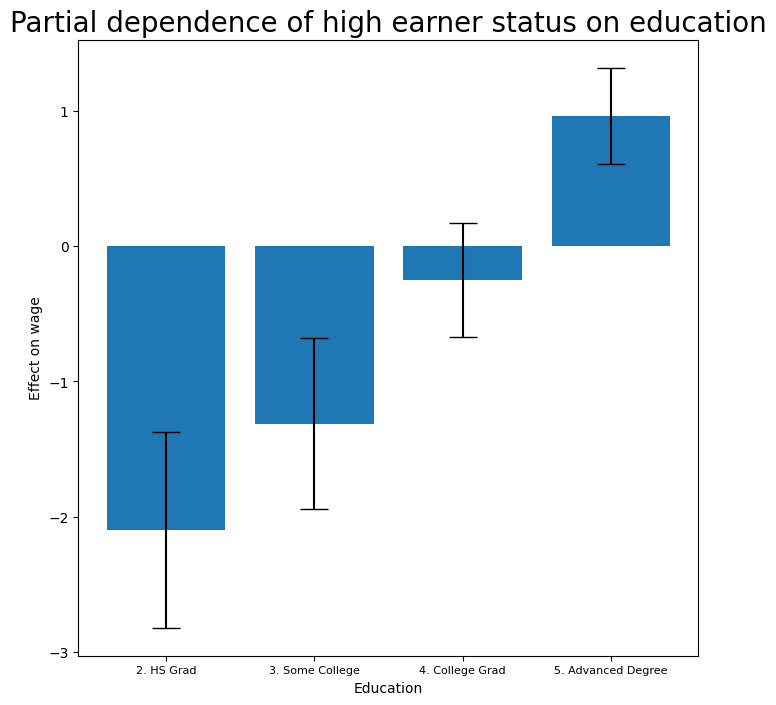

In [ ]:
gam_logit_ = LogisticGAM(age_term +
year_term +
f_gam(2, lam=0))
gam_logit_.fit(Xgam_, high_earn_)

fig, ax = subplots(figsize=(8, 8))
ax = plot_gam(gam_logit_, 2)
ax.set_xlabel('Education')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of high earner status on education' , fontsize=20);
ax.set_xticklabels(Wage['education'].cat.categories[1:],
fontsize=8);

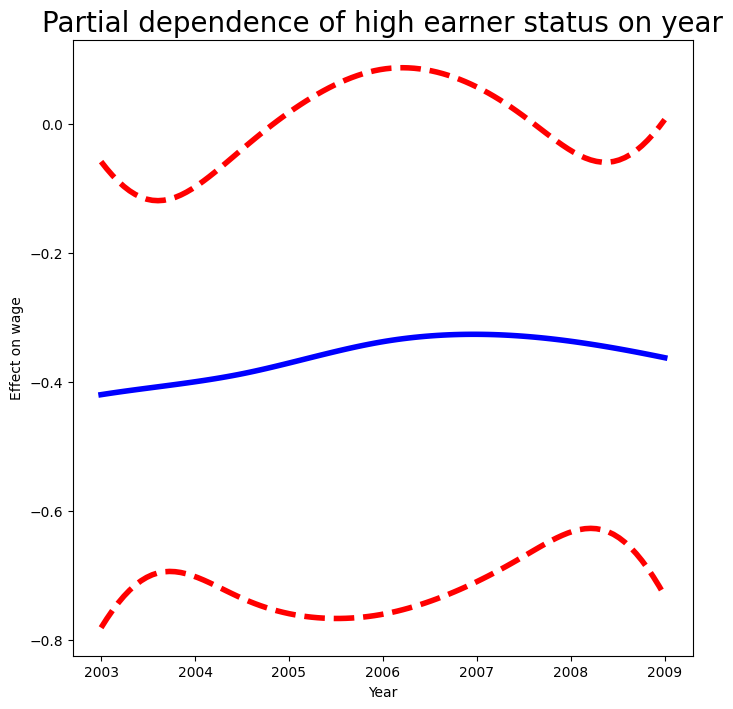

In [ ]:
fig, ax = subplots(figsize=(8, 8))
ax = plot_gam(gam_logit_, 1)
ax.set_xlabel('Year')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of high earner status on year',
fontsize=20);

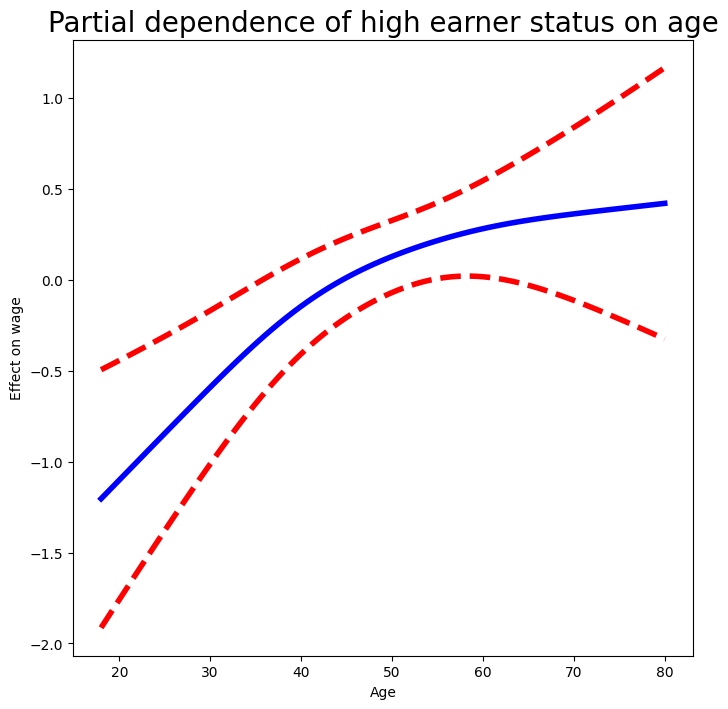

In [ ]:
fig, ax = subplots(figsize=(8, 8))
ax = plot_gam(gam_logit_, 0)
ax.set_xlabel('Age')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of high earner status on age',
fontsize=20);

# Bibliográfia
**James, G., Witten, D., Hastie, T., & Tibshirani, R. (2021). An Introduction to Statistical Learning, With Applications in Python. Springer.**
